# Final Project - CS634 Data Mining

## Using Random Forrest, Naive Bayes, GRU for heart deaths

### This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.

#### My project focuses on implementing various machine learning classification algorithms, along with a deep learning model, to predict the likelihood of heart failure patients related deaths. The predictions are based on specific diagnostic measurements provided in the dataset. Data source: https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records

## Module 1: Import Libraries
Purpose: This module imports all the libraries and packages required for data preprocessing, visualization, model building, and evaluation.
**Key Libraries:**
- pandas, numpy for data handling and numerical operations.
- seaborn, matplotlib for visualization.
- sklearn for machine learning models and metrics.
- keras for building and training the GRU deep learning model.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Module 2: Load and Prepare the Dataset
Purpose:
 - Reads the dataset from a CSV file into a Pandas DataFrame.
 - Splits the data into features (X) and the target variable (y).
 - Standardizes the feature values to bring all columns to the same scale.
 - Visualizes the distribution of the target variable (DEATH_EVENT) to check for data imbalance.
 - Prints the counts and percentages of positive (1) and negative (0) outcomes.

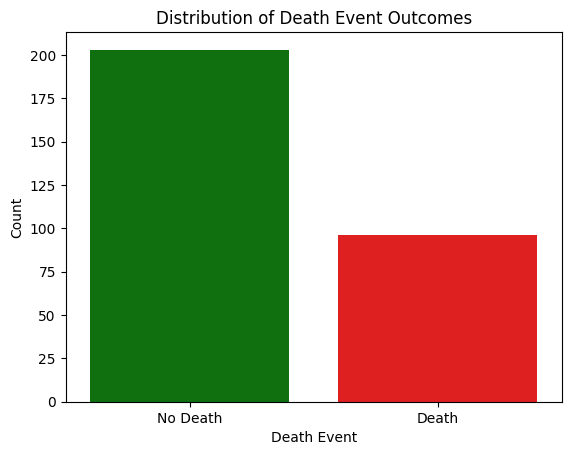


----------Checking for Data Imbalance------------
Number of Positive Outcomes (Death): 203
Percentage of Positive Outcomes (Death): 67.89%
Number of Negative Outcomes (No Death): 96
Percentage of Negative Outcomes (No Death): 32.11%



In [4]:
# Load dataset
heart = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Split dataset into features (X) and target variable (y)
X = heart.drop(columns=['DEATH_EVENT'])  # Features
y = heart['DEATH_EVENT']  # Target

# Standardize features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Visualize the distribution of the target variable using a bar chart
sns.countplot(x=y, hue=y.astype(str), palette={'0': 'green', '1': 'red'}, legend=False)
plt.title("Distribution of Death Event Outcomes")
plt.xlabel("Death Event")
plt.ylabel("Count")
plt.xticks([0, 1], ['No Death', 'Death'])  # Update x-axis labels
plt.show()

# Check for data imbalance
positive_outcomes, negative_outcomes = y.value_counts()
total_samples = y.count()
print("\n----------Checking for Data Imbalance------------")
print(f'Number of Positive Outcomes (Death): {positive_outcomes}')
print(f'Percentage of Positive Outcomes (Death): {round((positive_outcomes / total_samples) * 100, 2)}%')
print(f'Number of Negative Outcomes (No Death): {negative_outcomes}')
print(f'Percentage of Negative Outcomes (No Death): {round((negative_outcomes / total_samples) * 100, 2)}%\n')


## Module 3: Data Correlation
Purpose:
 - Data read in previous module to find corralation between factors.
 - Correlation data will show how factors relate to death and explanation of values

Calculating correlations with target and features...



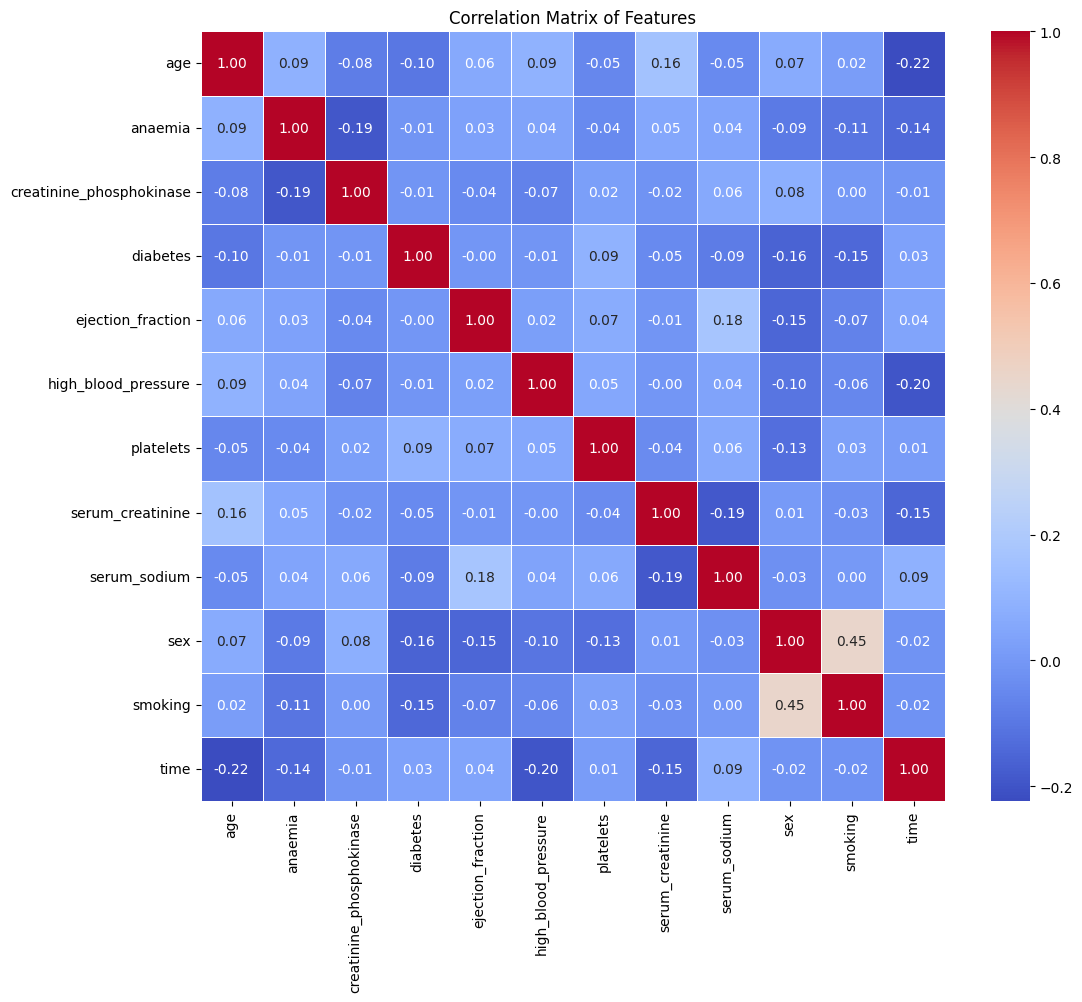

Correlation of features with DEATH_EVENT:
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
dtype: float64

Explanation of Correlations with 'DEATH_EVENT':

serum_creatinine: Weak positive correlation (Feature slightly increases, likelihood of death slightly increases).
age: Weak positive correlation (Feature slightly increases, likelihood of death slightly increases).
high_blood_pressure: Weak positive correlation (Feature slightly increases, likelihood of death slightly increases).
anaemia: Weak positive correlation (Feature slightly increases, likelihood of death slightly increases).
creatinine_p

In [5]:
# Split the data into features and target variable
X = heart.drop(columns=['DEATH_EVENT'])  # Features
y = heart['DEATH_EVENT']  # Target variable

# Correlation Analysis
print("Calculating correlations with target and features...\n")

# Calculate the correlation matrix for features
correlation_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Show the correlation of each feature with the target variable
correlation_with_target = X.corrwith(y).sort_values(ascending=False)
print("Correlation of features with DEATH_EVENT:")
print(correlation_with_target)

# Explanation of the correlation with DEATH_EVENT
print("\nExplanation of Correlations with 'DEATH_EVENT':\n")
for feature, correlation in correlation_with_target.items():
    if correlation > 0.5:
        print(f"{feature}: Strong positive correlation (Feature increases, likelihood of death increases).")
    elif correlation < -0.5:
        print(f"{feature}: Strong negative correlation (Feature increases, likelihood of death decreases).")
    elif correlation > 0:
        print(f"{feature}: Weak positive correlation (Feature slightly increases, likelihood of death slightly increases).")
    elif correlation < 0:
        print(f"{feature}: Weak negative correlation (Feature slightly increases, likelihood of death slightly decreases).")
    else:
        print(f"{feature}: No significant correlation with DEATH_EVENT.")

## Module 4: Define Metric Calculation Functions
Purpose:
 - Provides a reusable function calc_metrics() to calculate:
 - Confusion matrix metrics: TP (True Positives), TN (True Negatives), FP (False Positives), FN (False Negatives).
 - Performance metrics: Accuracy, Precision, F1-Score, TPR (Recall), TNR, FPR, and FNR.
 - These metrics are used to evaluate the models' performance.

In [6]:
# Define metric calculation functions
def calc_metrics(conf_matrix, y_test, predicted):
    TP, FN = conf_matrix[0][0], conf_matrix[0][1]
    FP, TN = conf_matrix[1][0], conf_matrix[1][1]
    Accuracy = accuracy_score(y_test, predicted)
    Precision = precision_score(y_test, predicted)
    F1_measure = f1_score(y_test, predicted)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy]
    return metrics

## Module 5: Cross-Validation and Evaluation and completion of program with outputs
Purpose:
 - Implements Stratified K-Fold Cross-Validation to ensure a balanced distribution of target classes in each fold.
 - Trains and evaluates three models: Random Forest, Naive Bayes, and GRU.
 - Collects performance metrics for each model across all folds.
 - Displays the metrics for each fold and calculates the average performance metrics for each model.

In [8]:
def get_metrics(model, X_train, X_test, y_train, y_test, is_gru=False):
    if is_gru:
        # Convert DataFrame to NumPy array and reshape
        X_train_array = X_train.to_numpy()
        X_test_array = X_test.to_numpy()
        X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
        X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
        model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)
        predicted = (model.predict(X_test_reshaped) > 0.5).astype(int)
    else:
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
    matrix = confusion_matrix(y_test, predicted, labels=[1, 0])
    metrics = calc_metrics(matrix, y_test, predicted)
    return metrics

def cross_validate_and_evaluate(X_train, y_train):
    cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

    results = {
        'RF': [],
        'Naive Bayes': [],
        'GRU': []
    }

    for iter_num, (train_index, test_index) in enumerate(cv_stratified.split(X_train, y_train), start=1):
        features_train, features_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        labels_train, labels_test = y_train[train_index], y_train[test_index]
        
        # Random Forest Model
        rf_model = RandomForestClassifier(min_samples_split=2, n_estimators=100)
        rf_metrics = get_metrics(rf_model, features_train, features_test, labels_train, labels_test)
        results['RF'].append(rf_metrics)
        
        # Naive Bayes Model
        nb_model = GaussianNB()
        nb_metrics = get_metrics(nb_model, features_train, features_test, labels_train, labels_test)
        results['Naive Bayes'].append(nb_metrics)
        
        # GRU Model
        gru_model = Sequential()
        gru_model.add(GRU(64, input_shape=(features_train.shape[1], 1), return_sequences=False))
        gru_model.add(Dropout(0.2))
        gru_model.add(Dense(1, activation='sigmoid'))
        gru_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        gru_metrics = get_metrics(gru_model, features_train, features_test, labels_train, labels_test, is_gru=True)
        results['GRU'].append(gru_metrics)

    # Create DataFrames for each model with iterations as rows and metrics as columns
    metric_names = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'F1_measure', 'Accuracy']
    rf_metrics_df = pd.DataFrame(results['RF'], columns=metric_names)
    nb_metrics_df = pd.DataFrame(results['Naive Bayes'], columns=metric_names)
    gru_metrics_df = pd.DataFrame(results['GRU'], columns=metric_names)

    print("\nRandom Forest Metrics Across Iterations:")
    print(rf_metrics_df.round(2))
    print("\nNaive Bayes Metrics Across Iterations:")
    print(nb_metrics_df.round(2))
    print("\nGRU Metrics Across Iterations:")
    print(gru_metrics_df.round(2))

    avg_metrics_rf = rf_metrics_df.mean()
    avg_metrics_nb = nb_metrics_df.mean()
    avg_metrics_gru = gru_metrics_df.mean()

    avg_performance_df = pd.DataFrame({
        'RF': avg_metrics_rf,
        'Naive Bayes': avg_metrics_nb,
        'GRU': avg_metrics_gru
    }).T

    print("\nAverage Performance Across 10 Iterations (Cross-Validation):")
    print(avg_performance_df.round(2))

# Run the cross-validation and evaluation using the heart dataset
cross_validate_and_evaluate(X, y)

C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\mkjil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step

Random Forest Metrics Across Iterations:
   TP  TN  FP  FN   TPR   TNR   FPR   FNR  Precision  F1_measure  Accuracy
0   6  20   0   4  0.60  1.00  0.00  0.40       1.00        0.75      0.87
1   6  18   2   4  0.60  0.90  0.10  0.40       0.75        0.67      0.80
2   8  17   3   2  0.80  0.85  0.15  0.20       0.73        0.76      0.83
3   7  17   3   3  0.70  0.85  0.15  0.30       0.70        0.70      0.80
4   8  19   1   2  0.80  0.95  0.05  0.20       0.89        0.84      0.90
5   8  18   2   2  0.80  0.90  0.10  0.20       0.80        0.80      0.87
6   6  21   0   3  0.67  1.00  0.00  0.33       1.00        0.80      0.90
7   5  18   3   4  0.56  0.86  0.14  0.44       0.62        0.59      0.77
8   7  19   2   2  0.78  0.90  0.10  0.22       0.78        0.78      0.87
9   8  18   2   1  0.89  0.90  0.10  0.11       0.80        0.84      0.90

Naive Bayes Metrics Across Iterations:
   TP  TN  FP  FN   TPR   TNR   FPR   FNR  Precision  

## The final output provides the average performance of three models (Random Forest, Naive Bayes, and GRU) across 10 iterations of cross-validation. Let me break down the columns to explain what each metric means:

### 1. TP (True Positives):
 - RF: 6.9, Naive Bayes: 4.9, GRU: 5.5
 - **Interpretation**: The number of true positive predictions (patients correctly identified as having the event of interest, i.e., death).
 - **Explanation**: A higher value indicates the model is better at correctly identifying positive cases (deaths).

### 2. TN (True Negatives):
 - RF: 18.5, Naive Bayes: 18.5, GRU: 19.4
 - **Interpretation**: The number of true negative predictions (patients correctly identified as not having the event, i.e., not dying).
 - **Explanation**: A higher value indicates the model is better at correctly identifying negative cases (survivors).

### 3. FP (False Positives):
 - RF: 1.8, Naive Bayes: 1.8, GRU: 0.9
 - **Interpretation**: The number of false positive predictions (patients incorrectly identified as having the event, i.e., dying when they survived).
 - **Explanation**: Lower values are better. Fewer false positives mean fewer patients are wrongly classified as at risk of death.

### 4. FN (False Negatives):
 - RF: 2.7, Naive Bayes: 4.7, GRU: 4.1
 - **Interpretation**: The number of false negative predictions (patients incorrectly identified as not having the event, i.e., surviving when they actually died).
 - **Explanation**: Lower values are better. Fewer false negatives mean fewer patients who actually died are classified as survivors.

### 5. TPR (True Positive Rate or Sensitivity):
 - RF: 0.72, Naive Bayes: 0.51, GRU: 0.57
 - **Interpretation**: The proportion of actual positive cases (deaths) that were correctly identified by the model.
 - **Explanation**: Higher values mean the model is better at identifying deaths. Random Forest (RF) has the best sensitivity, meaning it is the best at correctly identifying patients who actually died.

### 6. TNR (True Negative Rate or Specificity):
 - RF: 0.91, Naive Bayes: 0.91, GRU: 0.96
 - **Interpretation**: The proportion of actual negative cases (survivors) that were correctly identified by the model.
 - **Explanation**: Higher values mean the model is better at identifying survivors. GRU has the best specificity, meaning it correctly classifies survivors better than the other models.

### 7. FPR (False Positive Rate):
 - RF: 0.09, Naive Bayes: 0.09, GRU: 0.04
 - **Interpretation**: The proportion of actual negative cases (survivors) that were incorrectly identified as positive (death).
 - **Explanation**: Lower values are better. Fewer false positives mean fewer survivors are mistakenly classified as having died. GRU has the lowest false positive rate, meaning it makes fewer mistakes in classifying survivors.

### 8. FNR (False Negative Rate):
 - RF: 0.28, Naive Bayes: 0.49, GRU: 0.43
 - **Interpretation**: The proportion of actual positive cases (deaths) that were incorrectly identified as negative (survived).
 - **Explanation**: Lower values are better. Fewer false negatives mean fewer deaths are missed by the model. RF performs the best in this regard.

### 9. Precision:
 - RF: 0.81, Naive Bayes: 0.76, GRU: 0.87
 - **Interpretation**: The proportion of predicted positive cases (deaths) that were actually positive.
 - **Explanation**: Higher values mean the model is more accurate in predicting positive cases. GRU has the highest precision, indicating that when it predicts death, it’s more likely to be correct than the other models.

### 10. F1 Measure (F1 Score):
 - RF: 0.75, Naive Bayes: 0.60, GRU: 0.67
 - **Interpretation**: The harmonic mean of Precision and Recall. It is a balanced metric that takes both false positives and false negatives into account.
 - Explanation: Higher values mean the model has better overall performance. RF has the best F1 score, indicating it is better balanced in its performance of identifying both deaths and survivors.

### 11. Accuracy:
 - RF: 0.85, Naive Bayes: 0.78, GRU: 0.83
 - **Interpretation**: The proportion of correct predictions (both true positives and true negatives) out of all predictions.
 - **Explanation**: Higher values mean the model is more accurate overall. Both RF and GRU have the highest accuracy (83%), indicating they are both highly accurate in predicting both deaths and survivors.

### Summary of Key Insights:
#### •	Random Forest (RF):
 - Best at detecting true positives (deaths) with a TPR of 0.72.
 - Has the best balance of performance (F1 score: 0.75) and accuracy (85%).
 - Best at minimizing false negatives (FNR: 0.28).
#### •	Naive Bayes:
 - Has a lower TPR (0.51), meaning it misses more deaths compared to the others.
 - However, it still performs well in terms of accuracy (78%).
 - It has a higher FNR (0.49), so it fails to identify more deaths than RF or GRU.
#### •	GRU (Recurrent Neural Network):
 - Best specificity (0.96), meaning it excels at correctly identifying survivors.
 - High precision (0.83), meaning it rarely incorrectly classifies survivors as deaths.
 - Slightly lower F1 score and accuracy compared to RF, but performs well overall.
#### **Conclusion**:
 - Best Overall Model: RF is the best overall model, providing a good balance of high sensitivity (true positive rate), precision, and accuracy.
 - GRU: Although GRU has excellent specificity and precision, it falls slightly behind in terms of sensitivity and overall F1 score.
 - Naive Bayes: Performs okay but has the lowest true positive rate, meaning it misses many deaths.
Each model has strengths and weaknesses, and the choice of the best model may depend on whether the priority is minimizing false positives, false negatives, or achieving overall balance.
